# Dimensionality reduction and feature selection

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectFwe, f_classif
from sklearn.feature_selection import RFE

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import matplotlib.pyplot as plt
import seaborn as sns

### Introduction

Dimensionality reduction and feature selection are crucial techniques in the field of machine learning and data analysis. They aim to reduce the number of input variables in a dataset while retaining the most informative and relevant features. By eliminating redundant or irrelevant features, these techniques improve computational efficiency, alleviate the curse of dimensionality, and enhance model performance.

This investigation will focus on the Arcene https://archive.ics.uci.edu/ml/datasets/Arcene dataset. The task here falls into the binary classification category (with continuous features), i.e., we want to distinguish cancer versus normal patterns from mass-spectrometric data. However, the data consists of 10000 attributes with only 100 labeled observations. Moreover, 3000 variables are completely useless - they were added to the dataset as distractors.

The goal of this investigation is to obtain the best predictions and select the smallest possible subset of relevant input variables (features).

### Discussion about the task

#### High dimensionality

With 10000 attributes but only 100 labeled observations, the dataset suffers from a severe case of high dimensionality. This means that the ratio of features to samples is extremely imbalanced, which can lead to various issues.

High-dimensional datasets require more computational resources and time to process and analyze. Many machine learning algorithms struggle with scalability when confronted with such large feature spaces. The excessive number of dimensions can lead to increased model complexity, longer training times, and decreased efficiency.

#### Testing feature selection

I will test the selectors' algorithm's performance by evaluating the quality of class separation based on fitting the Support Vector Classifier (SVC) model with a radial basis function (RBF) kernel and a gamma value of 1/n_features. This method was mostly used in the paper by Guyon, I.M., Gunn, S.R., Ben-Hur, A. and Dror, G. (2004) Result Analysis of the NIPS 2003 Feature Selection Challenge. [1]

With 10 repetitions of 5-fold cross-validation, I can obtain a more robust evaluation of the algorithm's performance by averaging the results across multiple iterations. This approach provides a better understanding of how well the algorithm performs on the Arcene dataset, taking into account the inherent sparsity and limited labeled observations. 

#### Feature selection algorithms

Most methods give two possibilities for feature selection:
1. selecting features above a certain threshold
2. selecting a predetermined number of variables

Selecting variables based on a threshold can yield unexpected results, particularly in highly-dimensional data, as the performance metrics may exhibit peculiar behavior. Therefore, I have opted for the second option, which involves testing the algorithm's performance over a predetermined number of variables. This approach will allow me to determine the optimal number of variables and identify the algorithm that produces the best results. By systematically varying the number of variables, I aim to uncover the subset that maximizes performance.

The SelectKBest algorithm is a feature selection technique provided by the scikit-learn Python package. It is used to select the top k features from a given dataset based on their statistical significance. The algorithm operates by scoring each feature individually using a specific statistical metric, such as chi-squared, ANOVA F-value, or mutual information. I will use the ANOVA F-value score (f_classif).

RFE (Recursive Feature Elimination) is another feature selection algorithm provided by the scikit-learn Python package. It is a backward feature selection technique that iteratively removes the least important features from the dataset until a specified number of features is reached. The RFE algorithm works by fitting a model to the entire dataset and then ranking the features based on their importance scores. It then eliminates the feature with the lowest importance score and refits the model to the remaining features. This process is repeated until the desired number of features is obtained.

I will use RFE with 3 models to compare:
1. Support vector machine with the linear kernel (RFE_SVC)
2. Random Forest Classifier without any tuning (RFE_RFC)
3. Logistic regression with the lasso method (RFE_Lasso)

Sequential Feature Selection is also available in the scikit-learn Python package, but it's not practical. There are too many features and it would take too long.

Another method for dimensionality reduction is Principal Component Analysis, but in this task, the goal is feature selection, not dimension reduction.

[1] https://papers.nips.cc/paper_files/paper/2004/file/5e751896e527c862bf67251a474b3819-Paper.pdf

In [2]:
#import data from internet, run if data is not dowloaded
'''
path_html = "https://archive.ics.uci.edu/ml/machine-learning-databases/arcene/ARCENE/"
#import_list = "arcene_test.data arcene_train.data arcene_train.labels arcene_valid.data".split()
import_list = "arcene_train.data arcene_train.labels".split()
for item_name in import_list:
    pd.read_csv( path_html+item_name, index_col=False, sep=" ", header=None).to_csv(item_name,index=False)
'''

'\npath_html = "https://archive.ics.uci.edu/ml/machine-learning-databases/arcene/ARCENE/"\n#import_list = "arcene_test.data arcene_train.data arcene_train.labels arcene_valid.data".split()\nimport_list = "arcene_train.data arcene_train.labels".split()\nfor item_name in import_list:\n    pd.read_csv( path_html+item_name, index_col=False, sep=" ", header=None).to_csv(item_name,index=False)\n'

### Preprocessing of data

In [3]:
#labes are only for training dataset
labels = pd.read_csv("arcene_train.labels")["0"]
#there is artefact: column "10000" with all NA
#arcene_test = pd.read_csv("arcene_test.data").drop("10000", axis=1)
arcene_train = pd.read_csv("arcene_train.data").drop("10000", axis=1)
#arcene_valid = pd.read_csv("arcene_valid.data").drop("10000", axis=1)

In [4]:
#chceck, if there are constant columns
constant_columns = []
for column in arcene_train.columns:
    if len(arcene_train[column].unique()) == 1:
        constant_columns.append(column)
print("Number of constant columns: "+str(len(constant_columns)))

Number of constant columns: 80


In [5]:
#data exploration
print("arcene_train shape: "+str(arcene_train.shape))
print("Column types: int64: "+str( (arcene_train.dtypes == "int64").sum() )+" columns" )
print("Num of NA: "+str((arcene_train.isna()).sum().sum()))
print(f"All min: {arcene_train.min().min()} All max: {arcene_train.max().max()}")
print(f"Labales count: -1: {(labels==-1).sum()} 1: {(labels==1).sum()}")

arcene_train shape: (100, 10000)
Column types: int64: 10000 columns
Num of NA: 0
All min: 0 All max: 924
Labales count: -1: 56 1: 44


#### Evaluation function

I will use Cross Validation with 40 baches to access the best number of features to select.

Before applying the selector and assessing the accuracy of the data I remove constant features by using a Variance Threshold of 0 and normalizing the columns.

In [6]:
#methods will be evalueted by 
#SVM model as sugested in the paper
#with accuracy calculated by CV
def evaluate_cv( X, y, Selector, test_repetitions=1, cv_splits=5):
    
    pipeline = Pipeline( steps=[
        ('remove constant features', VarianceThreshold( threshold=0)),
        ('scaler', StandardScaler()),
        ('selector', Selector),
        ('model', SVC(gamma='auto'))
    ])
    
    cv = StratifiedKFold( n_splits=cv_splits, shuffle=True)

    num_selected_features_list = []
    accuracy_list = []
    
    for test_i in range(test_repetitions):
        for train_index, test_index in cv.split(X, y):
            # Fit selector on training data
            pipeline.fit(X.loc[train_index,], y[train_index])

            # Get the number of selected features
            num_selected_features = pipeline.named_steps['selector'].get_support().sum()
            num_selected_features_list.append( num_selected_features )

            # Evaluate accuracy on test data
            accuracy = pipeline.score( X.loc[test_index,], y[test_index])
            accuracy_list.append(accuracy)
    
    return accuracy_list, num_selected_features_list

In [7]:
#List of Number of Features to test
#[   8,   11,   14,   18,   23,   30,   39,   51,   67,   87,  112,
#        146,  190,  247,  321,  418,  543,  706,  917, 1193, 1550, 2015,
#       2620, 3406, 4428, 5756, 7483]
n_features_test_list = np.round( np.power( 1.3, np.arange(start=8, stop=35)) ).astype(int)

#List of Methods to test based on Number of Features
def methods_dict_n_features( n_features_to_select):
    methods_dict = {
        "SelectKBest": SelectKBest( score_func=f_classif, k=n_features_to_select),
        "RFE_SVC": RFE( SVC(kernel="linear"), n_features_to_select=n_features_to_select, step=0.1),
        "RFE_RFC": RFE( RandomForestClassifier(), n_features_to_select=n_features_to_select, step=0.1),
        "RFE_Lasso": RFE( Lasso(), n_features_to_select=n_features_to_select, step=0.1),
    }
    return methods_dict

In [10]:
#Testing loop
results = []
for n_features in n_features_test_list:
    print("#", end="")
    methods_dict = methods_dict_n_features( n_features)
    for methods_name, method in methods_dict.items():
        accuracy_list, num_selected_features_list = evaluate_cv( 
            arcene_train, labels, method, test_repetitions = 1, cv_splits = 40
        )
        
        for i in range(len(accuracy_list)):
            results.append([ methods_name, i, num_selected_features_list[i], accuracy_list[i]])     

###########################

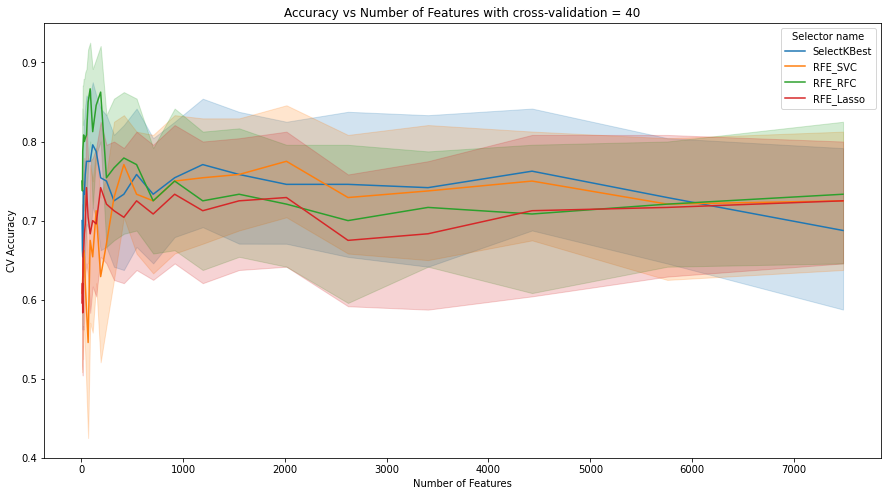

In [15]:
#Plot results
results_pd = pd.DataFrame( results )
results_pd.columns = ["Selector name", "experiment index", "number of features", "cv accuracy"]

plt.figure(figsize=(15,8))
# Plot line plot with whiskers
sns.lineplot(data=results_pd, x='number of features', y='cv accuracy', hue='Selector name', ci=95)

# Set plot labels and title
plt.xlabel('Number of Features')
plt.ylabel('CV Accuracy')
plt.title('Accuracy vs Number of Features with cross-validation = 40')

# Show the plot
plt.show()

In [18]:
# Group by 'Number of Features' and 'Selector name' and calculate the mean
grouped = results_pd.groupby(['number of features', 'Selector name']).agg({'cv accuracy': 'mean'})

# Find the maximum mean value and corresponding indices
max_mean = grouped['cv accuracy'].max()
max_indices = grouped[grouped['cv accuracy'] == max_mean].index

# Print the result
print("Maximum CV Accuracy Value:")
print(np.round(max_mean,2))
print("\nCorresponding 'Number of Features' and 'Selector name':")
for indices in max_indices:
    num_features, selector_name = indices
    print(f"Number of Features: {num_features}, Selector name: {selector_name}")

Maximum CV Accuracy Value:
0.87

Corresponding 'Number of Features' and 'Selector name':
Number of Features: 87, Selector name: RFE_RFC


### Results

The results showed that for a small number of features (less than 500), the RFE_RFC method performed the best in terms of predictive accuracy, followed by SelectKBest, RFE_Lasso, and RFE_SVC. This suggests that the Random Forest Classifier without any tuning was particularly effective in this scenario.

On the other hand, when dealing with a large number of features, all the methods yielded similar results, although they were generally worse compared to the performance achieved with a smaller number of features. This indicates that as the feature space expanded, the predictive accuracy of all the models decreased, likely due to the increased complexity and noise introduced by the additional variables.

Overall, the results of this investigation highlight the importance of feature selection when dealing with high-dimensional datasets. The Random Forest Classifier (RFE_RFC) and SelectKBest with ANOVA F-value score emerged as promising methods for achieving accurate predictions while minimizing the number of features.